In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function = embeddings,
    collection_name = 'income_tax_collection2',
    persist_directory = './income_tax_collection2'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
    
class AgentState(TypedDict):
    query: str
    context: list
    answer: str


In [4]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    query = state['query']
    context = state['context']
    rag_chain = generate_prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({'question':query, 'context':context})
    
    return {'answer': response}

In [ ]:
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    print(f'query: {query}')
    
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question':query, 'documents':context})
    print(f'response doc relevance: {response}')
    
    if response['Score'] == 1:
        return 'relevant'
    return 'irrelevant'
    

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate


rewrite_prompt = PromptTemplate.from_template("""
        사용자의 질문을 보고, 웹 검색에 용이하도록 사용자의 질문을 수정해주세요.
        질문: {question}    
""")


def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'question': query})
    print(f'rewrite question: {response}')
    return {'query': response}

In [ ]:
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults( # LLM이 직접 웹을 검색하기 위한 도구
    max_results = 3, # 검색 결과를 최대 3개 문서만 가져오도록 함.
    search_depth = "advanced", # 정확도가 향상된 검색을 수행함. / "basic": 빠르고 간단한 검색을 수행함.
    include_answer = True, # 검색 결과에 대한 Tavily의 답변을 포함시킴.
    include_raw_content = True, # 검색 결과에 웹 페이지의 원문 텍스트를 포함시킴.
    include_images = True # 검색 결과에 이미지 URL도 포함시킴.
)

def web_search(state: AgentState):
    query = state['query']
    results = search_tool.invoke(query) # 주어진 질문에 대해 웹 검색을 실행함. (list 타입의 값을 반환함.)
    print(f'web search results: {results}')
    return {'context': results}

In [10]:
graph_builder = StateGraph(AgentState)

In [11]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [12]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')

graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': 'rewrite',
    }
)

graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [13]:
graph = graph_builder.compile()

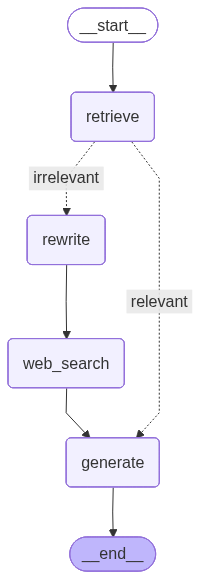

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initial_state = { 'query': '강남역 근처 맛집을 추천해주세요.'}

graph.invoke(initial_state)

query: 강남역 근처 맛집을 추천해주세요.
response doc relevance: {'Score': 0, 'Explanation': 'The facts provided are focused on tax laws and regulations, such as income tax, business reporting, and financial investment taxation. These topics are completely unrelated to the question about recommending a restaurant near Gangnam Station. There are no keywords or semantic meanings in the facts that relate to food, restaurants, or the Gangnam area, which are necessary to address the question. Therefore, the score is 0, indicating that the facts are completely unrelated to the question.'}
rewrite question: 
강남역 근처 인기 맛집 추천 리스트 부탁드립니다.
web search results: [{'url': 'https://www.youtube.com/watch?v=WVssZrCxG4A', 'content': "# 강남에서만 '16,790끼' 먹은 의사의 Best 5 맛집 소개🍽️\n## 솔직한 의사 생활\n3600 subscribers\n15 likes\n\n### Description\n1414 views\nPosted: 20 Feb 2025\n안녕하세요☺️\n오늘은 36년간 강남에 계셨던 원장님께서\n'강남역 찐맛집'을 추천해 주시는 영상을 준비해 봤는데요 ㅎㅎ\n수많은 음식점이 즐비하는 강남에서 뭘 먹어야 할지 고민이신 분들은 이 영상을 끝까지 시청해 주세요! \n-\nMade with Vrew\n–––––––––

{'query': '\n강남역 근처 인기 맛집 추천 리스트 부탁드립니다.',
 'context': [{'url': 'https://www.youtube.com/watch?v=WVssZrCxG4A',
   'content': "# 강남에서만 '16,790끼' 먹은 의사의 Best 5 맛집 소개🍽️\n## 솔직한 의사 생활\n3600 subscribers\n15 likes\n\n### Description\n1414 views\nPosted: 20 Feb 2025\n안녕하세요☺️\n오늘은 36년간 강남에 계셨던 원장님께서\n'강남역 찐맛집'을 추천해 주시는 영상을 준비해 봤는데요 ㅎㅎ\n수많은 음식점이 즐비하는 강남에서 뭘 먹어야 할지 고민이신 분들은 이 영상을 끝까지 시청해 주세요! \n-\nMade with Vrew\n––––––––––––––––––––––––––––––––––––––––––––––––––\n#주름 #흉터 #시술 #쥬브젠 #자가진피재생술 #쥬브젠자가진피재생술 #강남 #맛집 #강남맛집 #추천 #맛집추천 #의사 [...] 우리 어릴 때 먹던 짜장면 집이죠 근데 몇 년 전에 그것도 없어졌어요 그래서 참 섭섭하게 생각합니다 그러면 마지막 한길에 강남역 주변에서 드실 수 있다고 하면 가고 싶은 곳이 있으신가 손님을 배려하거나 그런게 아니고 내가 진짜 입맛 에 맞아서 가고 싶다 마지막 한끼를 강남역에서 먹는다면 나는 번 6번 출고 뒷골목에 가서 안동국시를 먹겠습니다 경상도 말로는 이제 정부지 김치라고 하는 건데 그다음에 이제 깻잎은 간장에 절인 거죠 그게 참 맛있습니다 결국은 뭔가 하면 사람은 누구나 그런가 봐요 아무리 맛있고 비싸고 호화로운 식사보다 어릴 때 먹었던 그런 음식이 제일 인상적인 거 같습니다 그런 것들이 정서적으로 끌리는 거 같아요 저번에 갔던데 그렇지 그죠 그러면 처음 병원을 개업하 때 딱 강남에 오셔서 드셨던 음식이 있으세요 지금도 있습니다 모퉁이 라면 집이라고요 바로 뒤에 있습니다 그분이 저보다 오래 되셨습니다 저는 90년도 초에 개